# 词袋模型图像分类

### 1. 数据加载

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F

In [3]:


class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, classes):
        self.dataset = dataset
        self.classes = classes
        self.filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in classes]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        original_idx = self.filtered_indices[idx]
        return self.dataset[original_idx]

# 加载完整的Fashion-MNIST数据集
full_dataset = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
# 加载测试数据集
test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
# 过滤出0-4类
filtered_dataset = FilteredDataset(full_dataset, classes=[0, 1, 2, 3, 4])
test_filtered_dataset = FilteredDataset(test_dataset, classes=[0, 1, 2, 3, 4])
# 创建数据加载器
data_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_filtered_dataset, batch_size=64, shuffle=True)

从DataLoader中获取一个batch数据看看

In [4]:
images, labels = next(iter(data_loader))
print(images.shape)
print(labels)
images, labels = next(iter(test_loader))
print(images.shape)
print(labels)

torch.Size([64, 1, 28, 28])
tensor([3, 1, 1, 1, 0, 0, 3, 2, 0, 0, 4, 0, 0, 3, 0, 4, 3, 3, 0, 0, 0, 1, 3, 2,
        3, 0, 0, 1, 2, 4, 1, 0, 3, 2, 3, 1, 2, 3, 4, 3, 3, 4, 4, 0, 2, 0, 1, 4,
        4, 4, 0, 4, 4, 2, 2, 1, 3, 2, 4, 2, 3, 0, 0, 2])
torch.Size([64, 1, 28, 28])
tensor([4, 3, 3, 0, 2, 4, 1, 2, 4, 3, 1, 1, 0, 3, 0, 4, 1, 0, 3, 1, 3, 0, 2, 0,
        0, 0, 0, 2, 2, 3, 2, 2, 1, 2, 2, 4, 1, 0, 3, 1, 3, 3, 4, 0, 3, 1, 4, 4,
        3, 1, 3, 3, 4, 3, 2, 1, 0, 4, 4, 0, 1, 0, 2, 4])


都是0-4范围内的标签，说明数据加载器没问题

### 2. SIFT特征提取器

In [5]:
import cv2
import numpy as np
def extract_sift_features(dataset):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        # 将图像从Tensor转换为NumPy数组，并调整为OpenCV格式
        image_np = image.numpy().squeeze() * 255
        image_np = image_np.astype(np.uint8)

        # 检测SIFT特征点并计算描述符
        keypoints, descriptors = sift.detectAndCompute(image_np, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    return all_descriptors

In [6]:

sift_features = extract_sift_features(filtered_dataset)
print(len(sift_features))


26257


### 3. 聚类得到视觉单词

In [7]:

from sklearn.cluster import KMeans

# 将所有描述符合并为一个大的NumPy数组
all_descriptors = np.vstack(sift_features)

# 设置聚类的视觉单词数量
num_clusters = 100

# 使用KMeans进行聚类
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

# 获取聚类中心，这些中心即为视觉单词
visual_words = kmeans.cluster_centers_

/home/steve1111/anaconda3/envs/cv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 4. 生成直方图并训练模型


In [8]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def compute_histogram(descriptors, visual_words):
    # 初始化直方图
    histogram = np.zeros(len(visual_words))
    # 计算每个描述符到视觉单词的距离
    for descriptor in descriptors:
        distances = np.linalg.norm(visual_words - descriptor, axis=1)
        # 找到最近的视觉单词
        nearest_word = np.argmin(distances)
        # 增加该视觉单词的计数
        histogram[nearest_word] += 1
    return histogram

# 为每个图像计算视觉单词直方图
def compute_histograms(dataset, visual_words):
    histograms = []
    labels = []
    for i in range(len(dataset)):
        sift = cv2.SIFT_create()
        image, label = dataset[i]
        image_np = image.numpy().squeeze() * 255
        image_np = image_np.astype(np.uint8)
        # 提取SIFT特征
        keypoints, descriptors = sift.detectAndCompute(image_np, None)
        if descriptors is not None:
            histogram = compute_histogram(descriptors, visual_words)
            histograms.append(histogram)
            labels.append(label)
    return np.array(histograms), np.array(labels)



In [13]:
# 计算训练集的直方图
train_histograms, train_labels = compute_histograms(filtered_dataset, visual_words)
# 计算测试集的直方图
test_histograms, test_labels = compute_histograms(test_filtered_dataset, visual_words)
print(train_histograms[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]


### 5. 训练并测试模型

In [15]:
# 创建并训练SVM模型
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_model.fit(train_histograms, train_labels)

# 在测试集上评估模型
y_pred = svm_model.predict(test_histograms)
accuracy = accuracy_score(test_labels, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 63.25%


### 6. 测试一张图片

original label: 3


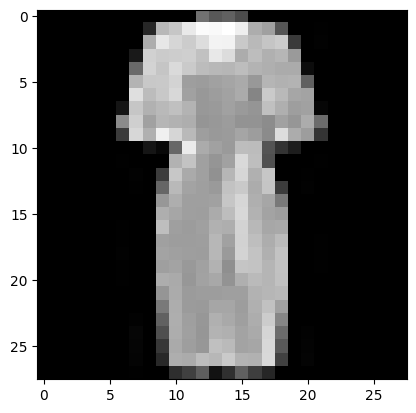

predicted label: [3]


In [19]:
import matplotlib.pyplot as plt

image, label = test_filtered_dataset[1586]
print('original label:', label)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()
# 提取SIFT特征并计算直方图
image_np = image.numpy().squeeze() * 255
image_np = image_np.astype(np.uint8)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image_np, None)
if descriptors is not None:
    histogram = compute_histogram(descriptors, visual_words)
    histogram = histogram.reshape(1, -1)  # 重塑为2D数组

output = svm_model.predict(histogram)
print('predicted label:', output)
